In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
class Timer(object):
    def __init__(self):
        self.total_time = 0.
        self.calls = 0
        self.start_time = 0.
        self.diff = 0.
        self.average_time = 0.

    def tic(self):
        self.start_time = time.time()

    def toc(self, average=True):
        self.diff = time.time() - self.start_time
        self.total_time += self.diff
        self.calls += 1
        self.average_time = self.total_time / self.calls
        if average:
            return self.average_time
        else:
            return self.diff
        
        
 

In [2]:
from keras.layers import Input,Conv2D,MaxPooling2D,ZeroPadding2D
from keras.layers import Flatten,BatchNormalization,Permute,TimeDistributed,Dense,Bidirectional,GRU
from keras.models import Model

import shutil
import numpy as np
from PIL import Image
import keras.backend  as K

from imp import reload 
import densenet
reload(densenet)

import os
from keras.layers import Lambda
from keras.optimizers import SGD

import tensorflow as tf  
import keras.backend.tensorflow_backend as K  
from matplotlib import pyplot as plt
import pandas as pd

import glob
import re

class PredictCheck:
    """
    images_dir: 批量验证图片的路径
    image_label: 批量验证图片的标记文件
    dicfile: 字符字典
    unih: 图片高度。
    modelPath:模型路径。
    """
    def __init__(self, images_dir, image_label, dicfile, unih, modelPath, gpu_fraction=0):
        self.dicfile = dicfile
        self.image_label = image_label
        self.images_dir = images_dir
        self.modelPath = modelPath
        self.unih = unih
        self.t = Timer()

        with open(self.image_label, encoding='utf-8') as f:
            self.labelFile = [str(line).strip() for line in f.readlines()]
        # 得到一个labelList
        self.labelCounter = len(self.labelFile)        
        self.labelList = []
        for i in self.labelFile:
            fname = i.split(" ")[0]
            findex = len(fname)
            aclabel = i[findex:]
            aclabel = aclabel.strip()
            self.labelList.append([fname, aclabel])
        
        tmp = self.__get_session__(gpu_fraction)
        K.set_session(tmp)
        
        self.char = ""
        with open(self.dicfile, encoding='utf-8') as f:
            for ch in f.readlines():
                ch = ch.strip('\r\n')
                self.char = self.char + ch
        print('xxnclass:',len(self.char))
        print(self.char)
        self.char =self.char[1:]+'卍'
        self.nclass = len(self.char)
        print('nclass:',self.nclass)
        self.id_to_char = {i:j for i,j in enumerate(self.char)}
        input = Input(shape=(self.unih,None,1),name='the_input')
        y_pred= densenet.dense_cnn(input,self.nclass)
        self.basemodel = Model(inputs=input,outputs=y_pred)
        self.basemodel.load_weights(self.modelPath)        
        
    def __get_session__(self, gpu_fraction=0.8):  
        '''''Assume that you have 6GB of GPU memory and want to allocate ~2GB'''  
        num_threads = os.environ.get('OMP_NUM_THREADS')  
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)  

        if num_threads:  
            return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))  
        else:  
            return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))  

    def __predict__(self, img_path):
        self.t.tic()
        img = Image.open(img_path)
        im = img.convert('L')
        scale = im.size[1]*1.0 / self.unih
        w = im.size[0] / scale
        w = int(w)
        print('w:',w)

        im = im.resize((w,self.unih),Image.ANTIALIAS)
        img = np.array(im).astype(np.float32)/255.0-0.5
        X  = img.reshape((self.unih,w,1))
        X = np.array([X])


        y_pred = self.basemodel.predict(X)

        argmax = np.argmax(y_pred, axis=2)[0]

        y_pred = y_pred[:,:,:]
        out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :]
        out = u''.join([self.id_to_char[x] for x in out[0]])
        self.t.toc()
        print("times,",self.t.diff)
        return out,im
        
    def loopPredict(self):
        self.result = []
        for img in glob.glob(f"{self.images_dir}/*.jpeg"):
            fname = os.path.basename(img)
            b, ximg = self.__predict__(img)
            self.result.append([fname, b, img])
        ## 就在这里通过dataframe进行join操作。
        aaa = pd.DataFrame(np.array(self.labelList), columns=['fileName', 'labelContent'])
        bbb = pd.DataFrame(np.array(self.result), columns=['fileName', 'predictContent', 'filePath'])
        self.ccc = pd.merge(aaa, bbb, on='fileName')
        ## 二者做一个join操作。。
        self.ccc['RW'] = np.where(self.ccc['labelContent'] == self.ccc['predictContent'], 'Right', 'Wrong')
        self.ccc.sort_values(['RW'], inplace=True)
        self.ccc.reset_index(drop=True, inplace=True)
        
    def compare(self, suffix="", same="same", diff="diff"):
        # 分割成两个文件夹，分别放置全对的和非全对的。。
        # 遍历预测的东西。看看是否在，label中，如果在的话，
        same = suffix + same
        diff = suffix + diff
        self.rightList = []
        self.wrongList = []
        if os.path.exists(same):
            shutil.rmtree(same)
        if os.path.exists(diff):
            shutil.rmtree(diff)
        os.mkdir(same)
        os.mkdir(diff)
        with open(os.path.join(same,same+".txt"), "w" , encoding='utf-8') as rf, open(os.path.join(diff, diff+".txt"), "w" , encoding='utf-8') as wf:
            for i in self.result:
                tmp  = i[0] + " " + i[1]
                if tmp in self.labelFile:
                    # 识别正确。。
                    shutil.copy2(os.path.join(self.images_dir, i[0]), same)
                    self.rightList.append(i)
                    rf.write(tmp+"\n")
                else:
                    shutil.copy2(os.path.join(self.images_dir, i[0]), diff)
                    self.wrongList.append(i)
                    wf.write(tmp+"\n")
    def displot(self, Right=True, n_size=10):
        # 把图片显示出来。。
        # n_size = -1表示使用对应的长度。。
        self.rightCounter = -1
        self.wrongCounter = -1
        if Right:
            self.rightCounter = 0
            if n_size > len(self.rightList) or n_size < 0:
                n_size = len(self.rightList)
            # 然后显示指定数量的图片
            for i in self.rightList:
                plt.imshow(Image.open(i[2]))
                plt.title(i[0] + "===" + i[1])
                print(i[0] + "===" + i[1])
                plt.show()
                self.rightCounter += 1
            print(f"总的图片数量是{self.labelCounter},其中正确的是{self.rightCounter},正确率为{self.rightCounter * 100.0 /self.labelCounter}")                 

        else:
            self.wrongCounter = 0
            if n_size > len(self.wrongList) or n_size < 0:
                n_size = len(self.wrongList)

            for i in self.wrongList:
                plt.imshow(Image.open(i[2]))
                plt.title(i[0] + "===" + i[1])          
                print(i[0] + "===" + i[1])
                plt.show()
                self.wrongCounter += 1
            print(f"总的图片数量是{self.labelCounter},错误的是{self.wrongCounter},正确率为{100.0 - self.wrongCounter * 100.0 /self.labelCounter}")                 

    def searchCase(self, srchPatten=r"填票人"):
        tmpResult = self.ccc[self.ccc.labelContent.str.match(srchPatten) | self.ccc.predictContent.str.match(srchPatten)]
        tmpResult.reset_index(drop=True, inplace=True)
        print(f"搜索匹配到的图片数量是{len(tmpResult)},具体分布情况是{tmpResult.RW.value_counts()}")
        for i in range(len(tmpResult)):
                plt.imshow(Image.open(tmpResult.iloc[i][-2]))
                plt.title(f"{tmpResult.iloc[i][0]}==={tmpResult.iloc[i][2]}")          
                print(f"{tmpResult.iloc[i][-1]}==={tmpResult.iloc[i][0]}==预测值={tmpResult.iloc[i][2]}==label值={tmpResult.iloc[i][1]}")
                plt.show()





Using TensorFlow backend.
/root/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# 当前目录是：/workspace/densent_ocr是docker镜像中的目录

In [ ]:
x = PredictCheck(images_dir="./ybt_test_images/pad_only_chinese_test_set_debug", 
                 image_label="./ybt_test_images/only_chinese1.txt",
                dicfile="./only_chinese_chn.txt",
                 unih=28,
                 modelPath="./ybt_model_weights/weights_densenet-09-9.79.h5",
                 gpu_fraction=0
                )

In [ ]:
x.loopPredict()
x.compare(suffix="ybt")

In [ ]:
x.displot(Right=False, n_size=100)

In [3]:
print(os.getcwd())

/workspace/densent_ocr


In [4]:
lz = PredictCheck(images_dir="./lz_test_images", 
                 image_label="./lz_labels/digit_test_tmp.txt",
                dicfile="./char_jehjxx.txt",
                 unih=22,
                 modelPath="./lz_model_weights/digit_20190214_1070.h5",
                 gpu_fraction=0
                )

xxnclass: 14
 0123456789.,￥
nclass: 14


In [5]:
lz.loopPredict()
lz.compare(suffix="lz")


w: 265
times, 1.6430706977844238
w: 265
times, 0.20997190475463867
w: 265
times, 0.2225666046142578
w: 265
times, 0.22159409523010254
w: 265
times, 0.2223682403564453
w: 265
times, 0.2264566421508789
w: 265
times, 0.21855831146240234
w: 265
times, 0.21329283714294434
w: 265
times, 0.21666765213012695
w: 265
times, 0.21572566032409668
w: 265
times, 0.22778987884521484
w: 265
times, 0.23727917671203613
w: 265
times, 0.23804473876953125
w: 265
times, 0.22699475288391113
w: 265
times, 0.22476625442504883
w: 265
times, 0.2210836410522461
w: 265
times, 0.23792219161987305
w: 265
times, 0.23809552192687988
w: 265
times, 0.2370131015777588
w: 265
times, 0.22181272506713867
w: 265
times, 0.23249363899230957
w: 265
times, 0.22535443305969238
w: 265
times, 0.22384381294250488
w: 265
times, 0.22216224670410156
w: 265
times, 0.22930049896240234
w: 265
times, 0.22083520889282227
w: 265
times, 0.22242140769958496
w: 265
times, 0.2191939353942871
w: 265
times, 0.22279787063598633
w: 265
times, 0.22617

times, 0.2870006561279297
w: 265
times, 0.27584123611450195
w: 265
times, 0.2719573974609375
w: 265
times, 0.27083373069763184
w: 265
times, 0.2804558277130127
w: 265
times, 0.273756742477417
w: 265
times, 0.272930383682251
w: 265
times, 0.27167439460754395
w: 265
times, 0.2872159481048584
w: 265
times, 0.3007338047027588
w: 265
times, 0.2935361862182617
w: 265
times, 0.28156065940856934
w: 265
times, 0.2744433879852295
w: 265
times, 0.2774624824523926
w: 265
times, 0.30202817916870117
w: 265
times, 0.2894437313079834
w: 265
times, 0.27402448654174805
w: 265
times, 0.2740025520324707
w: 265
times, 0.2760009765625
w: 265
times, 0.2777397632598877
w: 265
times, 0.2828373908996582
w: 265
times, 0.2733030319213867
w: 265
times, 0.2753310203552246
w: 265
times, 0.2755715847015381
w: 265
times, 0.28711605072021484
w: 265
times, 0.28404831886291504
w: 265
times, 0.2791740894317627
w: 265
times, 0.27715587615966797
w: 265
times, 0.2802159786224365
w: 265
times, 0.2954554557800293
w: 265
times,

times, 0.3355553150177002
w: 265
times, 0.3316342830657959
w: 265
times, 0.33979010581970215
w: 265
times, 0.34210872650146484
w: 265
times, 0.33243322372436523
w: 265
times, 0.33493518829345703
w: 265
times, 0.3477509021759033
w: 265
times, 0.3411695957183838
w: 265
times, 0.33408021926879883
w: 265
times, 0.3409147262573242
w: 265
times, 0.3499424457550049
w: 265
times, 0.3502821922302246
w: 265
times, 0.34209203720092773
w: 265
times, 0.33597254753112793
w: 265
times, 0.34064388275146484
w: 265
times, 0.3437831401824951
w: 265
times, 0.33882617950439453
w: 265
times, 0.33742594718933105
w: 265
times, 0.3408174514770508
w: 265
times, 0.34789204597473145
w: 265
times, 0.3369710445404053
w: 265
times, 0.3402390480041504
w: 265
times, 0.3408334255218506
w: 265
times, 0.3512840270996094
w: 265
times, 0.34802961349487305
w: 265
times, 0.33754539489746094
w: 265
times, 0.33966588973999023
w: 265
times, 0.35752391815185547
w: 265
times, 0.34372854232788086
w: 265
times, 0.34146881103515625


6462_2.jpeg===11015350


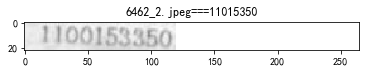

6221_32.jpeg===30000.40181005571


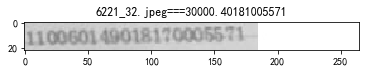

6463_19.jpeg===320170714000408062


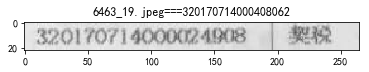

5177_7.jpeg===0207581.5


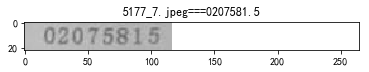

6430_28.jpeg===￥605,553.00


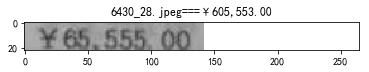

4203_6.jpeg===001870831


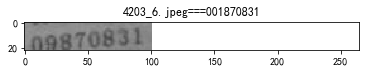

249_9.jpeg===101021083040845


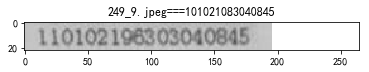

6629_0.jpeg===100182350


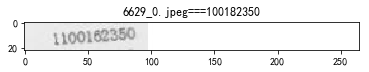

187_25.jpeg===￥0,033.0


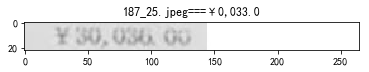

5176_42.jpeg===790


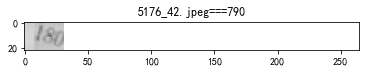

179_36.jpeg===￥83,800.532


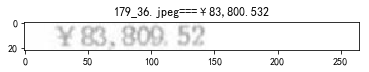

125_21.jpeg===015,000.00


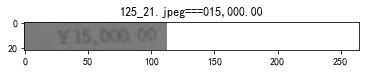

5037_1.jpeg===03769355010102350


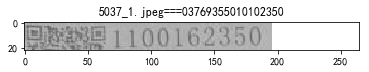

4165_22.jpeg===677077,22


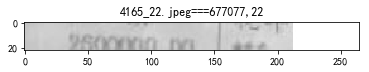

6441_25.jpeg===￥151708.,806


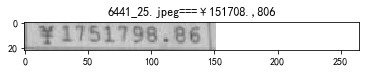

4158_43.jpeg===00000


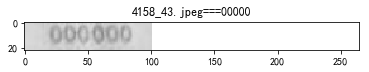

224_17.jpeg===28,800.09


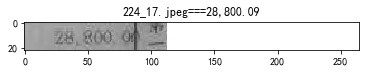

230_23.jpeg===￥028,075.00


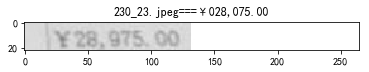

5041_25.jpeg===51571500,001


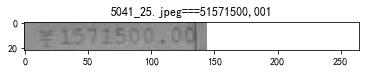

6631_3.jpeg===100162350


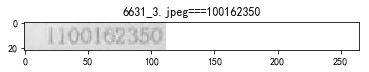

6435_28.jpeg===￥30,00.00


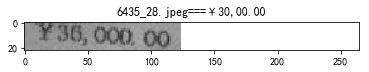

6474_2.jpeg===013505010162301


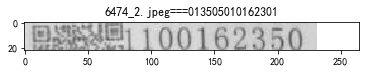

6623_52.jpeg===.2110113


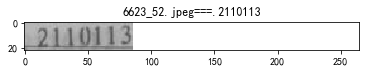

4002_35.jpeg===0.42841


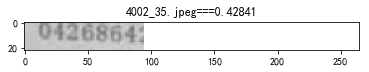

6618_28.jpeg===20000.001


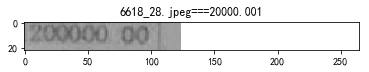

6639_5.jpeg===1001864350


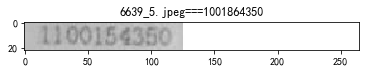

6682_17.jpeg===1102210580232722


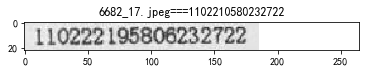

6618_9.jpeg===014.4331.083


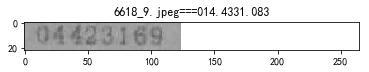

5012_21.jpeg===340821075102518


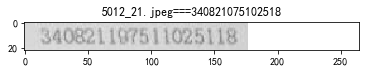

6229_2.jpeg===73020607


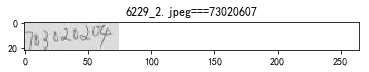

4177_11.jpeg===1007.1040707770


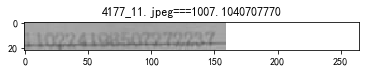

4025_49.jpeg===2,213.00.08


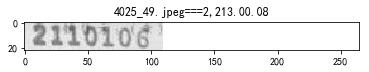

255_2.jpeg===9001


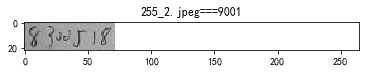

230_13.jpeg===475.030


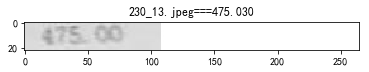

4211_32.jpeg===￥10,500.00


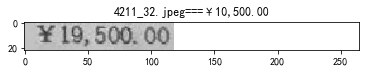

4241_29.jpeg===37,405.00


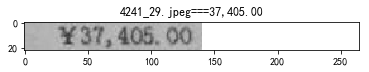

5167_12.jpeg===0030183231


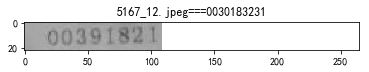

3038_11.jpeg===3000.00


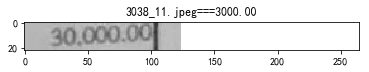

246_17.jpeg===28,000.00


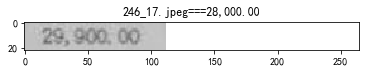

6475_7.jpeg===0010070


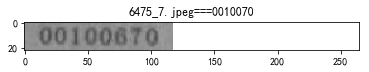

4173_15.jpeg===10102105503253023


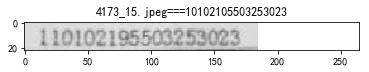

6220_24.jpeg===110102051082127


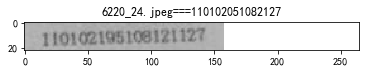

177_36.jpeg===071.33


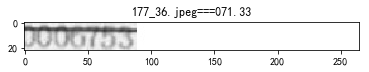

4229_25.jpeg===059,075,00


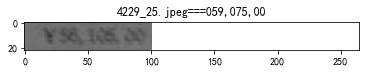

4033_28.jpeg===3201410528003547


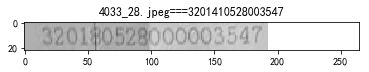

6481_19.jpeg===0013,10001.00


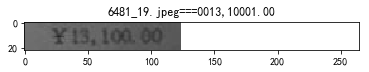

6690_6.jpeg===1101682350


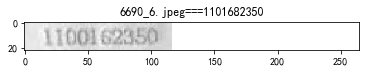

251_22.jpeg===10,700.0030


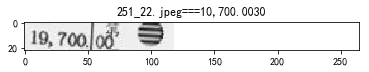

6626_40.jpeg===1428571.48


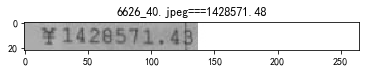

6429_19.jpeg===71,500.00


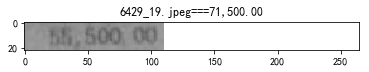

4203_33.jpeg===023740000.00


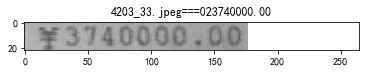

6624_3.jpeg===14700187..520


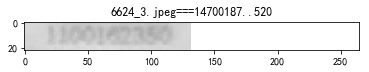

5159_12.jpeg===0104.01.52


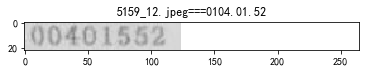

6631_5.jpeg===.0507113.0


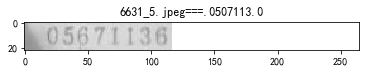

6652_17.jpeg===32017123000.048086


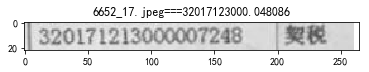

6636_22.jpeg===￥2050000.00.


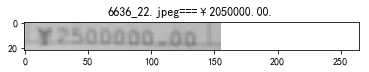

6655_37.jpeg===￥130000.0,00


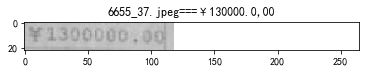

178_11.jpeg===131120107510020


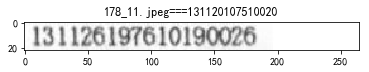

6420_33.jpeg===7111


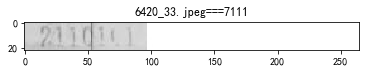

5032_45.jpeg===￥200000.00


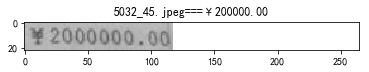

6410_21.jpeg===32017052700.43080


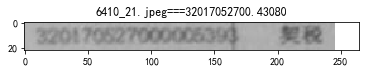

6626_9.jpeg===101


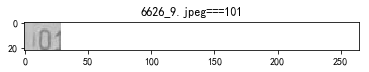

6464_23.jpeg===142571.683


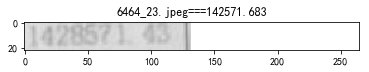

6424_38.jpeg===777779


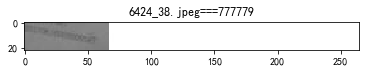

179_31.jpeg===705,100.43


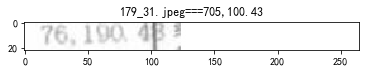

6449_2.jpeg===0404211


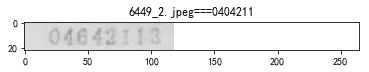

5030_40.jpeg===00000


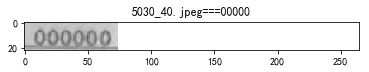

6630_38.jpeg===212103.05


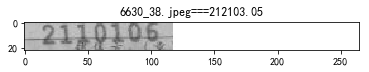

50_5.jpeg===2066


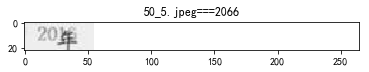

6420_34.jpeg===548570000.00


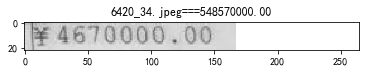

227_46.jpeg===32016010080003108


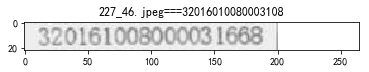

4202_4.jpeg===1045318


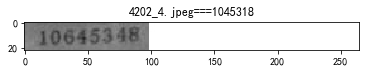

4202_18.jpeg===1060002073


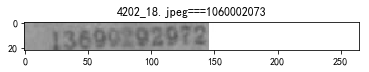

6626_13.jpeg===077381201


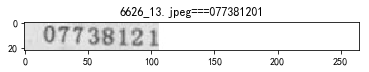

4026_3.jpeg===03543260,1170230


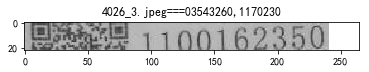

5159_39.jpeg===3.101.06


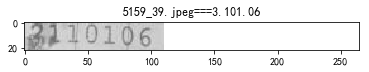

4231_13.jpeg===1302031074030241.4


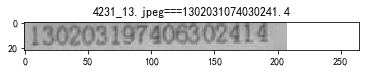

6626_54.jpeg===211013


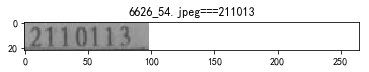

6454_23.jpeg===3740000.0008


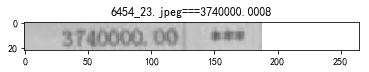

227_14.jpeg===1101081084070412137


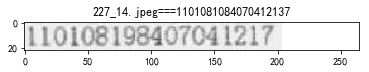

7021_1.jpeg===7


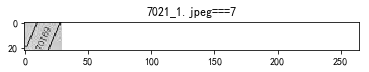

6608_24.jpeg===￥1.6000.00


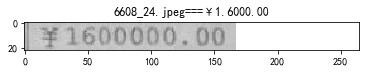

5012_12.jpeg===20160


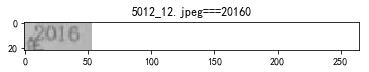

5177_24.jpeg===404702.40


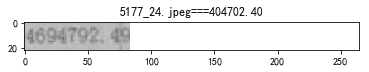

227_48.jpeg===2,723.81,1


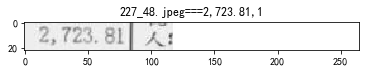

4002_67.jpeg===25.1.1011037


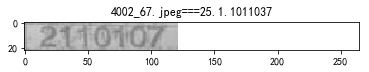

5041_3.jpeg===07770101013050


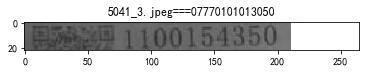

4051_36.jpeg===35350000,00


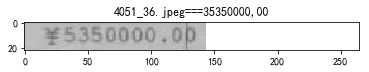

3063_22.jpeg===12,00.00


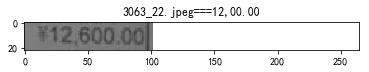

6641_5.jpeg===0100154350


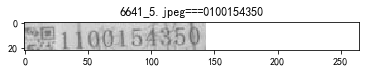

202_24.jpeg===0149,3536.20


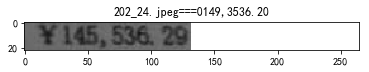

6650_26.jpeg===0008


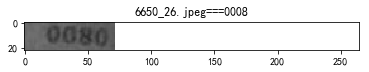

4009_21.jpeg===410,288.281


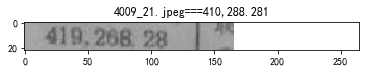

251_30.jpeg===3￥10,700.00


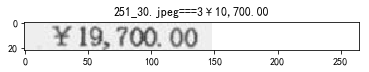

187_22.jpeg===30,036.609


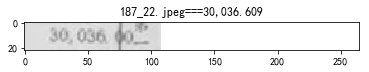

3054_4.jpeg===751100162350


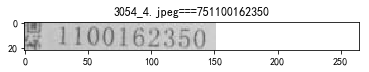

6636_5.jpeg===20018235


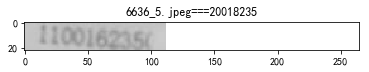

255_11.jpeg===34000307011.00220


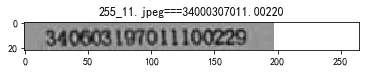

6630_22.jpeg===653.7221404.30003


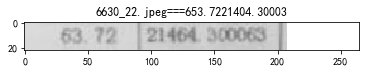

121_3.jpeg===0370001


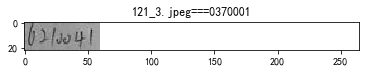

203_30.jpeg===3201020002288


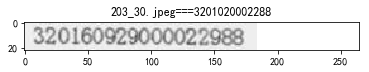

4208_4.jpeg===.1001.02330


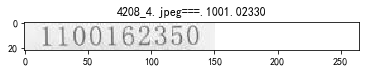

6446_13.jpeg===0047633132


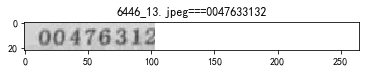

264_13.jpeg===6227221080030010


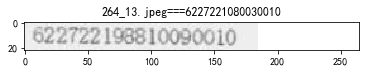

121_24.jpeg===￥335,100.00


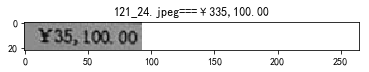

6633_48.jpeg===060


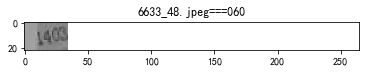

267_19.jpeg===14,225.7


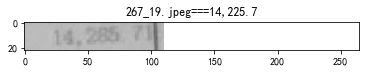

5024_27.jpeg===18513824150


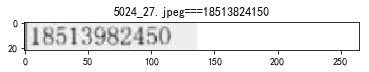

234_1.jpeg===7700179


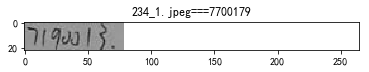

5012_42.jpeg===￥7207,30.53


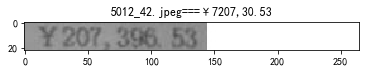

6617_7.jpeg===0080148


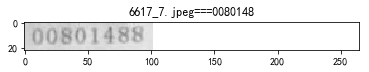

6207_4.jpeg===1100180235


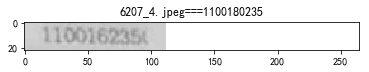

5168_22.jpeg===3201610207100767


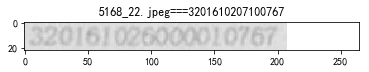

230_17.jpeg===265,500.0


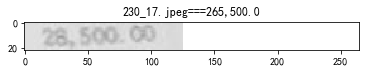

253_28.jpeg===￥653,705.00


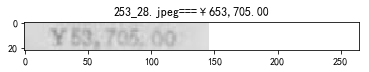

4032_29.jpeg===￥30,008.00


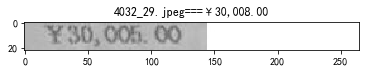

5177_5.jpeg===100154350


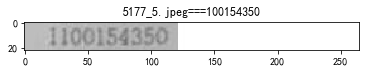

2_23.jpeg===￥5424302


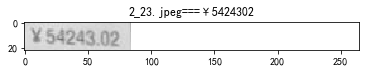

5037_26.jpeg===10800.0008


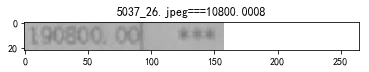

6438_6.jpeg===00170585


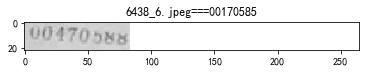

6483_8.jpeg===083801001.04.30


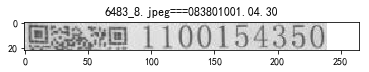

7007_2.jpeg===322086.7


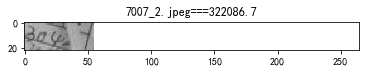

204_33.jpeg===￥30,300.00


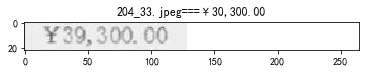

6475_3.jpeg===01753010102350


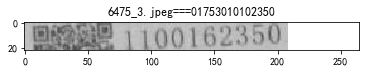

6498_26.jpeg===1.1.200000.00


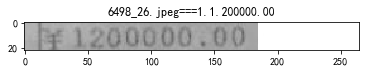

6640_32.jpeg===￥542000.00


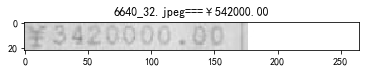

6474_30.jpeg===￥22.0000.00


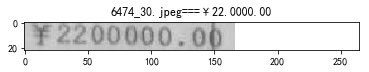

4025_4.jpeg===0537095


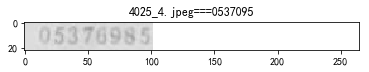

6225_23.jpeg===18518035071


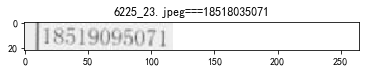

6225_41.jpeg===13910230135


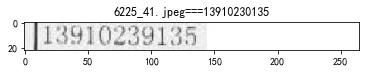

6690_33.jpeg===2111011080


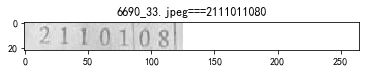

4000_59.jpeg===1.73,.308


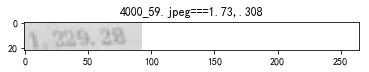

6630_5.jpeg===058.71120


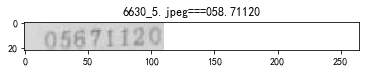

6472_34.jpeg===3080000.,00


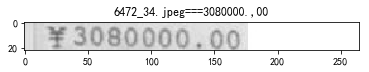

5420_17.jpeg===15,0000


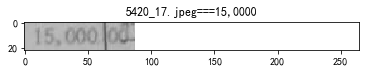

6449_25.jpeg===7255.00010.00


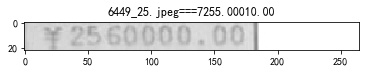

6617_34.jpeg===￥38052.38


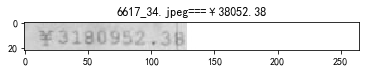

7015_8.jpeg===7170,52117


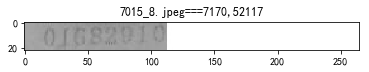

6463_29.jpeg===070,00.00


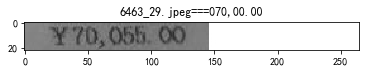

7008_42.jpeg===13527516


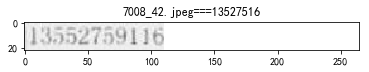

227_41.jpeg===320180100800031458


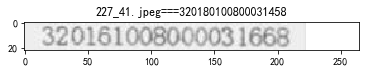

6225_37.jpeg===185103700101


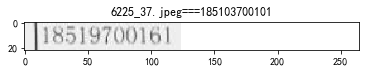

6475_31.jpeg===￥3000003


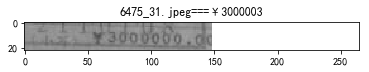

4025_28.jpeg===20101000.01


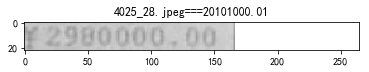

6480_20.jpeg===78,330.0005


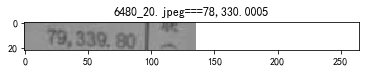

5176_39.jpeg===971


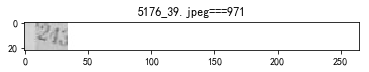

6655_57.jpeg===0071.30,030


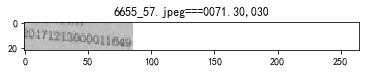

7023_13.jpeg===010068,101012413,50101


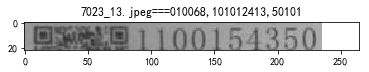

6639_28.jpeg===8.11014


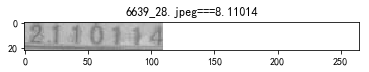

6626_23.jpeg===3801067352


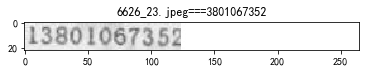

6466_27.jpeg===14,035.71


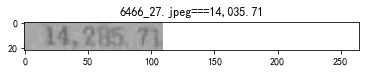

6438_28.jpeg===29182.8737


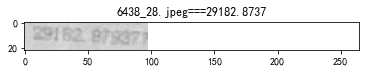

206_10.jpeg===3030210851142514


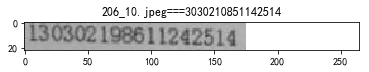

4229_22.jpeg===50,700.00


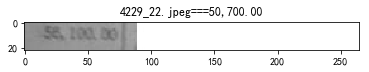

4184_6.jpeg===008705322


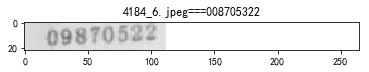

5030_2.jpeg===0152501001.54350


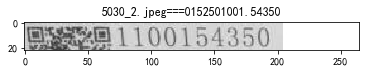

6242_8.jpeg===11001482350


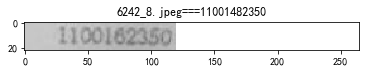

5037_5.jpeg===00337.34


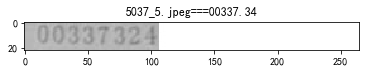

221_22.jpeg===,171.1717


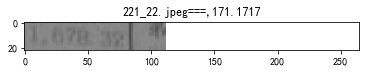

6655_34.jpeg===7,11014


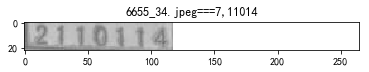

5422_26.jpeg===￥0,200.00


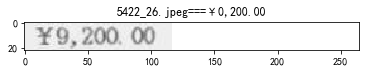

4017_15.jpeg===1324301045022700235


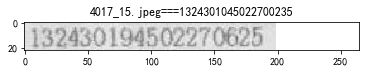

4033_23.jpeg===320140280003547


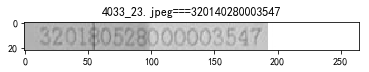

4022_34.jpeg===77130,10000438,


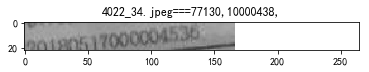

215_9.jpeg===320410087083102314


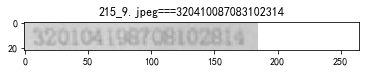

7010_14.jpeg===20036208


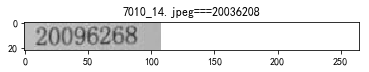

6613_5.jpeg===0587087


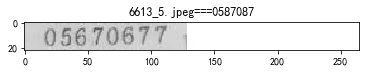

6462_5.jpeg===03428700


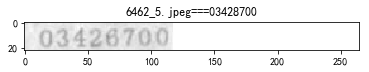

6416_30.jpeg===￥150,000.00


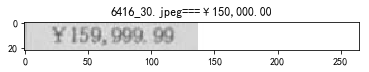

6626_51.jpeg===1301.053203


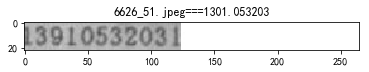

31_6.jpeg===103


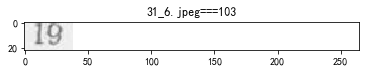

41_25.jpeg===15,00000


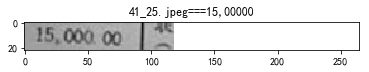

5023_18.jpeg===320140800.03406080


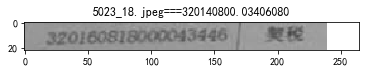

6454_7.jpeg===01405804


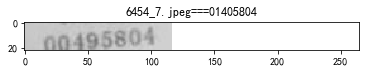

5032_17.jpeg===0031107


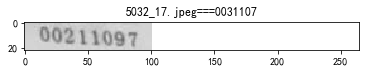

4165_1.jpeg===081638501001.023500


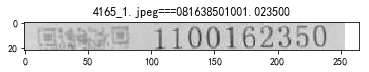

6690_34.jpeg===￥150007.20


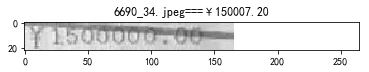

4226_38.jpeg===2280387,6532


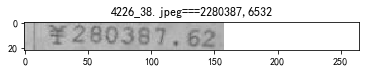

6619_7.jpeg===0422651


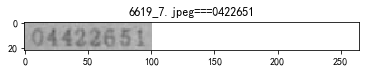

7008_16.jpeg===2510000.0


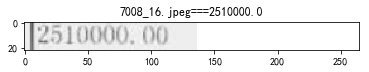

177_10.jpeg===8320201083404041227


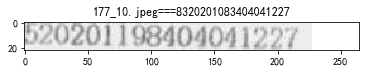

7006_4.jpeg===0025682


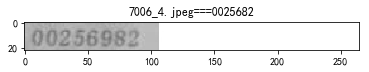

3061_30.jpeg===￥84844.13


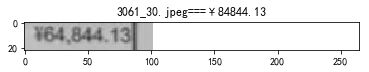

264_35.jpeg===￥20,000.00


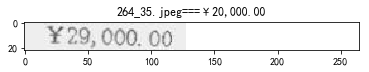

3006_21.jpeg===￥50,005,00


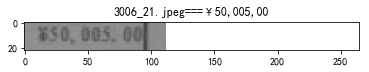

6446_40.jpeg===￥2314722.51


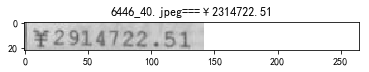

92_10.jpeg===3018113000720


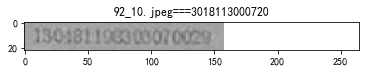

6488_7.jpeg===01.285084


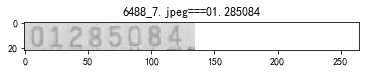

6633_7.jpeg===100031


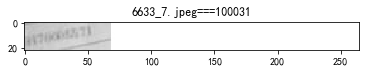

4151_49.jpeg===113070200741


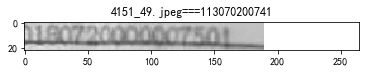

6455_5.jpeg===20107


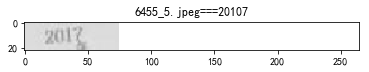

6605_28.jpeg===￥2850702,002


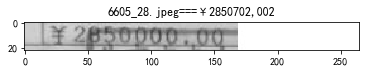

3054_8.jpeg===1488783


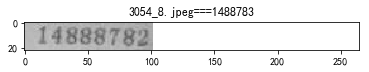

215_22.jpeg===15.08.00


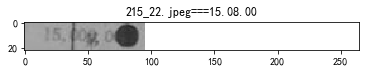

6445_4.jpeg===20170703032383


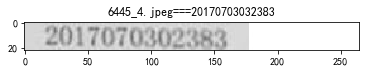

5041_2.jpeg===7177167190


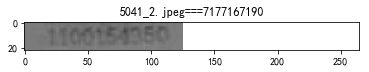

5166_7.jpeg===1880014142


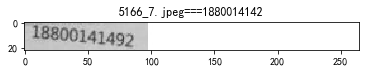

6448_28.jpeg===9.170.0


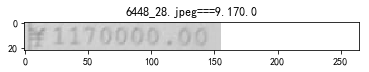

4009_26.jpeg===2,457.0


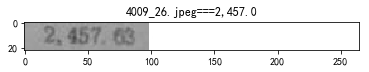

179_11.jpeg===11223108203170503.


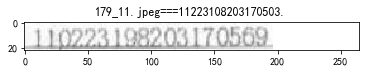

6420_6.jpeg===023403758


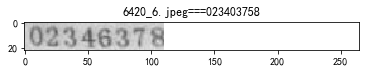

6690_8.jpeg===005585


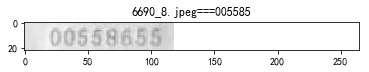

6441_0.jpeg===00.0101602350


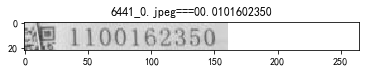

227_23.jpeg===320161008000031008


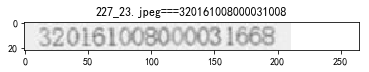

6682_9.jpeg===77


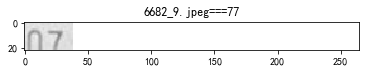

7009_12.jpeg===130932101032257


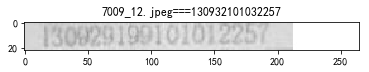

267_24.jpeg===￥14,231.7


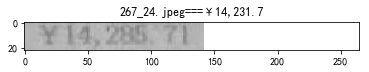

5043_56.jpeg===02700,0


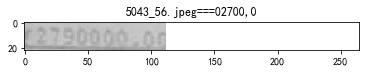

227_37.jpeg===6,800.525


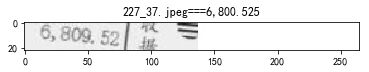

6223_11.jpeg===370303187507245711


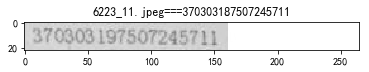

5020_7.jpeg===00015230


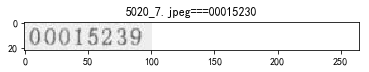

6462_28.jpeg===141.174146533.605318


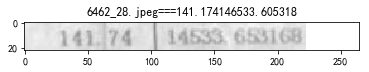

6455_23.jpeg===320170710000064.00


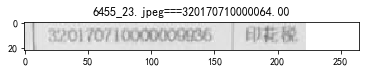

6462_33.jpeg===720010.00


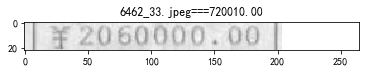

4202_22.jpeg===200000.0.0


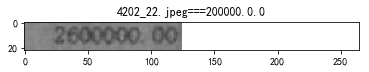

6206_15.jpeg===130015335


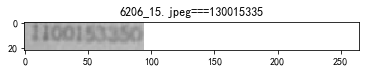

5177_48.jpeg===1021101.03


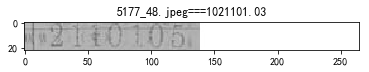

6448_4.jpeg===004768331


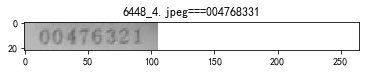

202_10.jpeg===51011107203054


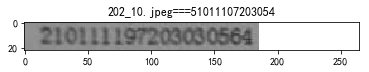

200_21.jpeg===￥015,000.00


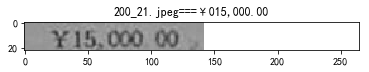

4051_2.jpeg===568350100162350


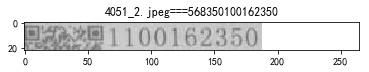

5401_10.jpeg===60127231037070010


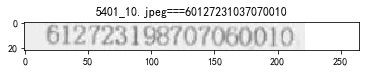

5037_11.jpeg===4200101.08211050416


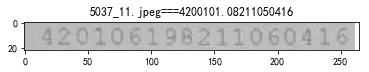

5176_12.jpeg===0065630


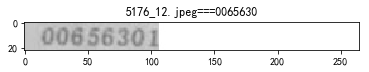

34_18.jpeg===400500


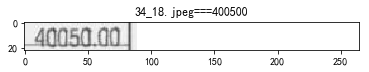

121_33.jpeg===8300000008


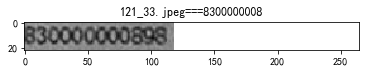

227_9.jpeg===2045


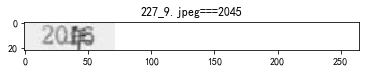

273_25.jpeg===￥07,840.00


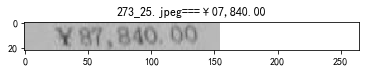

3061_16.jpeg===2,04723


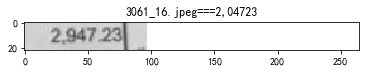

5166_12.jpeg===003841


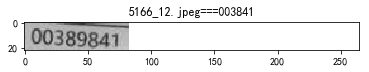

6464_2.jpeg===0303101016,230


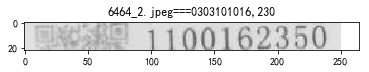

88_28.jpeg===￥210,800.00


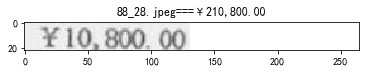

7007_34.jpeg===13430810800


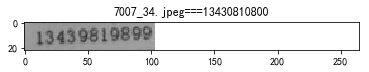

6617_5.jpeg===12001564350


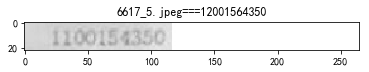

4231_26.jpeg===￥180,000.00


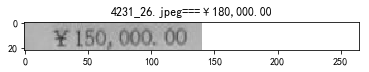

4043_7.jpeg===201823


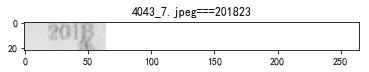

5008_4.jpeg===710717279700


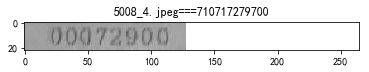

28_12.jpeg===20160


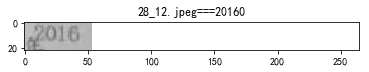

6449_0.jpeg===10162350


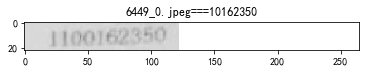

270_15.jpeg===62010510850214105


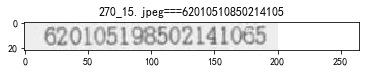

234_4.jpeg===034


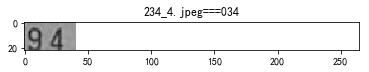

5039_24.jpeg===320100010042324


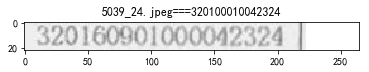

4005_42.jpeg===￥25620000.00


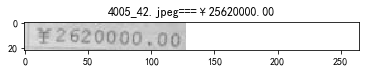

5043_53.jpeg===270000.0.005


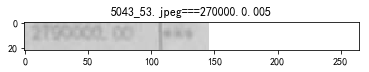

4226_29.jpeg===280387.82


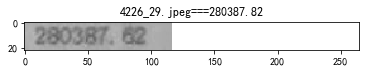

7006_25.jpeg===405,520,0,56


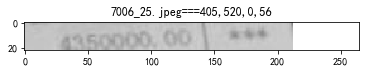

6617_36.jpeg===03101114


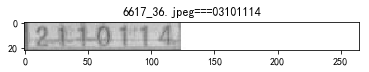

203_36.jpeg===￥210,723.80


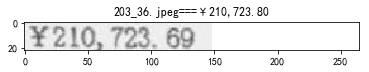

28_42.jpeg===￥7207,30.53


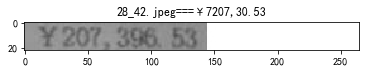

4033_29.jpeg===￥5.906.4


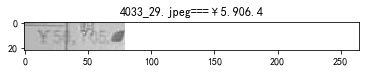

196_24.jpeg===42,000.,.7


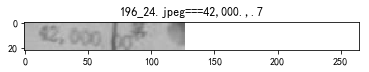

67_24.jpeg===320100010042324


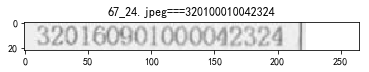

5014_23.jpeg===32016081000153017


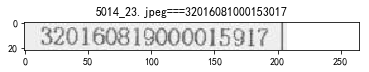

6641_30.jpeg===053740000.00


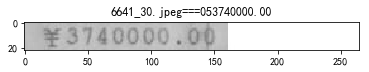

6640_7.jpeg===00800.42


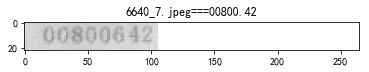

214_13.jpeg===4304221070110314


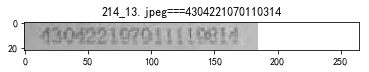

6472_1.jpeg===31001.623350


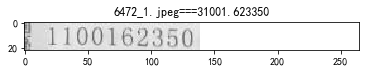

4202_40.jpeg===1306811720


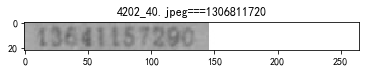

6446_14.jpeg===0283500513560


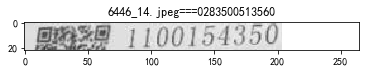

6464_29.jpeg===1.42835171.43


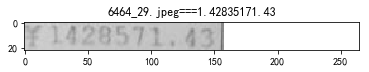

216_2.jpeg===020317


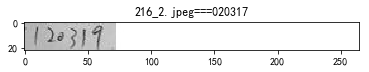

4009_33.jpeg===8,00.70


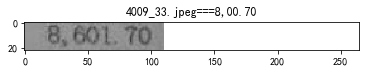

247_9.jpeg===010302100233014


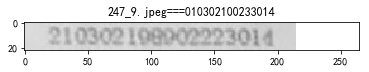

6477_0.jpeg===0023450.0.


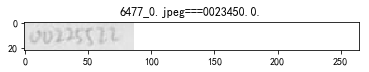

6691_10.jpeg===37078108002015


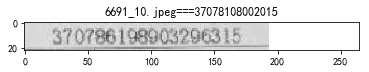

4026_5.jpeg===04203245


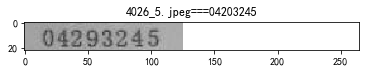

213_27.jpeg===￥120,000.00


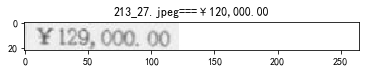

6641_25.jpeg===111.8731.88175


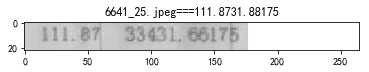

6475_44.jpeg===13,10000000,00


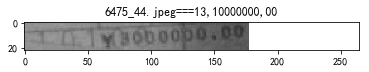

6462_27.jpeg===80009


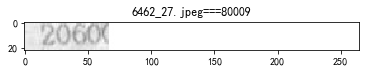

7005_8.jpeg===4210871085708035048


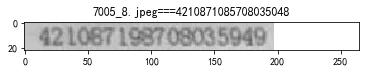

6464_24.jpeg===87,076771.0,70


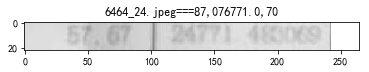

221_10.jpeg===0117101701


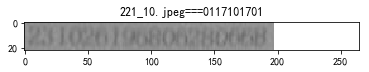

5008_34.jpeg===￥730001001.001


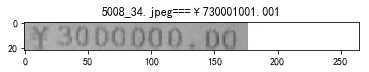

67_11.jpeg===60101231080105101


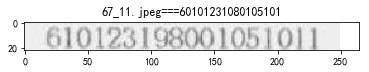

7008_38.jpeg===18020600


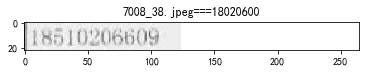

6483_12.jpeg===0168316810


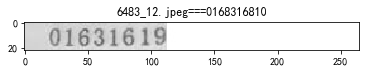

4158_23.jpeg===1500000.0099


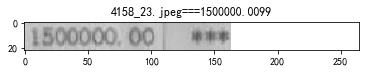

196_30.jpeg===￥42,00.00


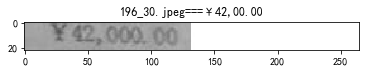

5176_15.jpeg===195.34200104


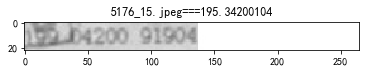

6462_4.jpeg===50,21101.8330


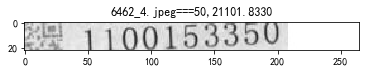

6474_4.jpeg===1100165235


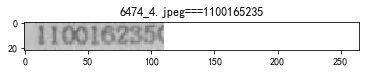

206_27.jpeg===24,300.07


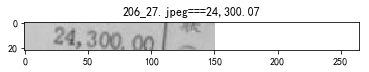

6475_27.jpeg===￥390000.00


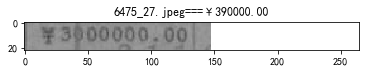

4049_28.jpeg===1520010.0


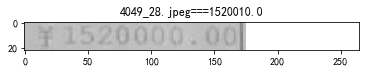

4188_8.jpeg===820758


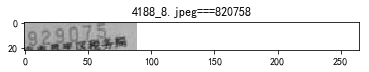

6666_9.jpeg===1010310302351


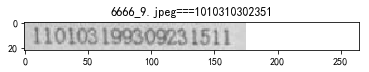

6626_41.jpeg===771428,.51


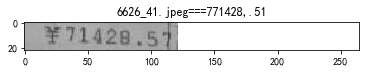

6458_48.jpeg===700847


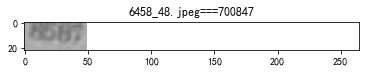

6455_26.jpeg===￥33,0355.00


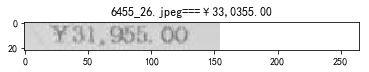

4033_9.jpeg===37085110881031.4020


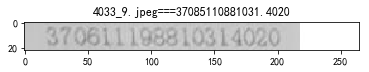

7006_29.jpeg===0435,0000.00


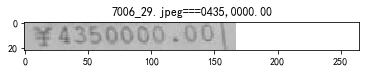

6446_10.jpeg===100154350


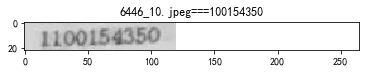

264_23.jpeg===320102300004305


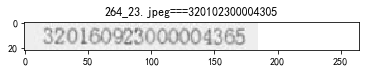

88_26.jpeg===320100800021837


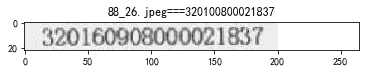

6430_9.jpeg===5102108052783


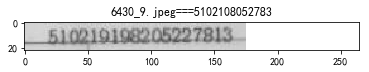

3053_20.jpeg===1860,501.00


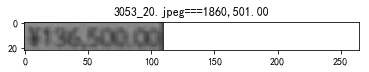

6629_2.jpeg===01738145


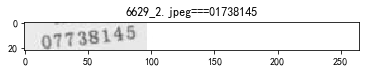

234_18.jpeg===22,500.0001


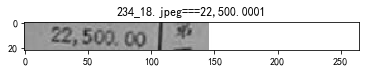

5043_34.jpeg===030101172350


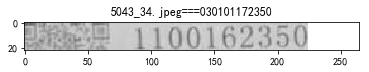

5007_9.jpeg===832010162350


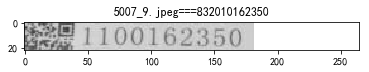

6480_25.jpeg===￥70,344.80


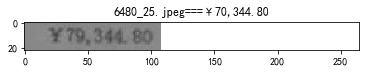

5160_42.jpeg===786.234


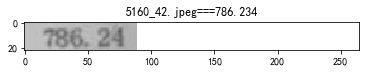

4191_7.jpeg===09834354


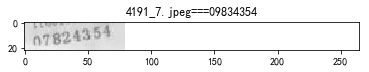

4226_6.jpeg===0398724.4


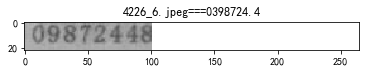

5177_13.jpeg===1.1.01.01070521.4032


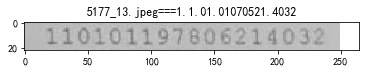

31_23.jpeg===32016081000153017


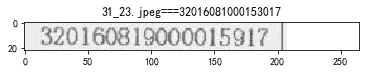

6655_30.jpeg===320132135


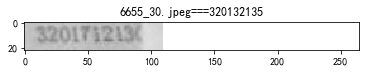

6629_16.jpeg===1102210800724623


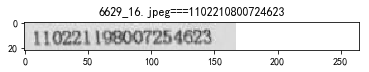

6244_12.jpeg===370070,1030710200071


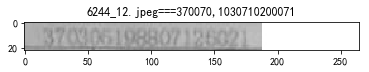

6242_13.jpeg===38,30


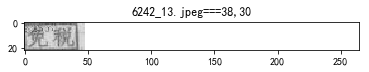

5024_43.jpeg===183101435316


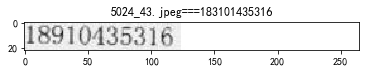

5418_27.jpeg===0.07,7001.00


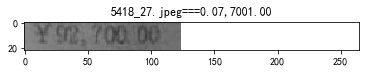

5401_25.jpeg===￥1600,543.10


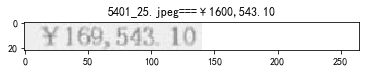

6410_8.jpeg===1521011012250280


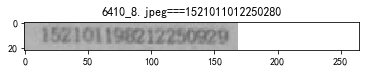

6635_50.jpeg===0023


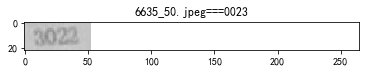

6424_23.jpeg===7031,17.05


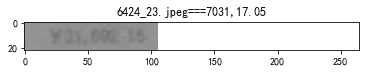

6639_43.jpeg===00000


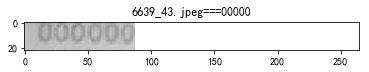

6639_29.jpeg===05370000.0


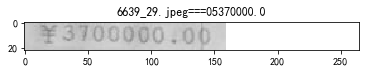

5421_25.jpeg===￥04,300.001


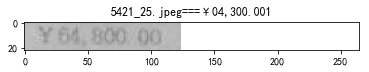

99_12.jpeg===11011102428825


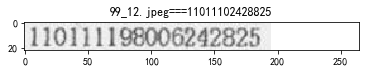

6631_33.jpeg===5748470.42


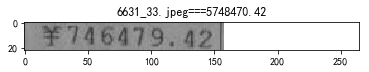

4172_9.jpeg===110010230


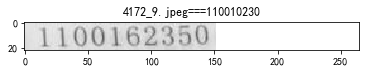

6498_2.jpeg===034003200101.0230


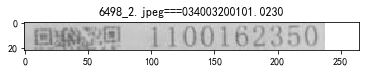

7010_17.jpeg===320170308000001080


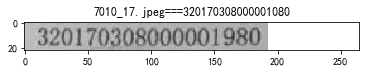

227_51.jpeg===￥211,7883.60


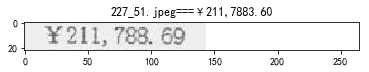

31_5.jpeg===20


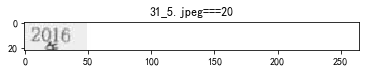

7006_0.jpeg===8253010154.35500


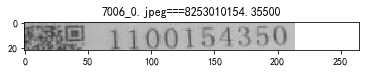

5177_25.jpeg===34730.6062


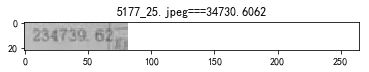

6472_33.jpeg===11710171


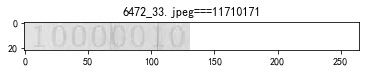

5020_3.jpeg===0303,27,10102350


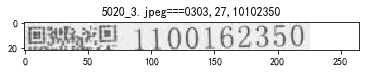

6242_53.jpeg===721171114


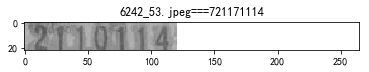

6221_65.jpeg===637713


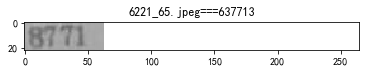

5014_6.jpeg===103


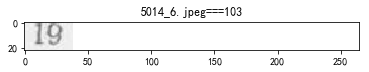

265_10.jpeg===0127201000180078


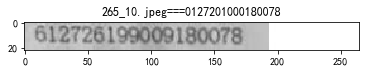

6206_5.jpeg===002400000006


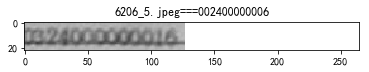

6623_37.jpeg===40000.00


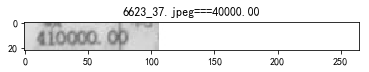

5418_11.jpeg===430203187010025


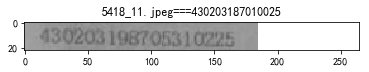

5032_10.jpeg===0350501010162.3,0


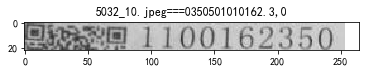

5160_30.jpeg===110014001817000571


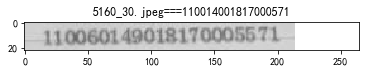

4242_21.jpeg===82,100.00


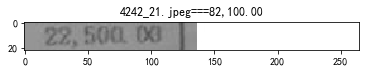

5041_24.jpeg===2110103


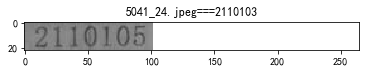

5030_13.jpeg===1.1010310850721.1242


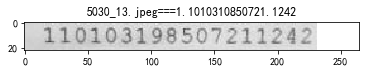

3002_25.jpeg===30,005.00


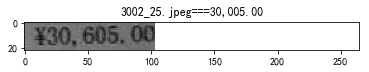

5158_13.jpeg===1101083105610242745


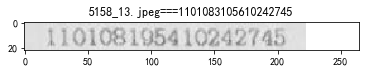

4051_13.jpeg===4302810850186035


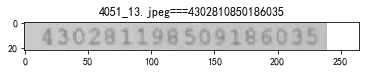

31_33.jpeg===￥40,500.00


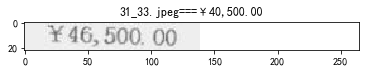

4005_15.jpeg===00884845


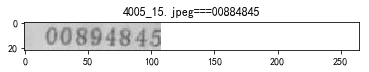

5041_18.jpeg===107170,0010


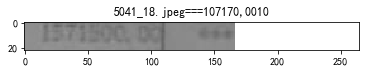

4013_24.jpeg===￥40,000.00


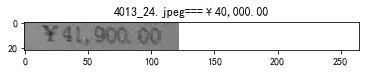

5014_13.jpeg===11010210511415334


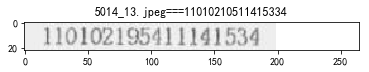

4049_4.jpeg===0125001010230


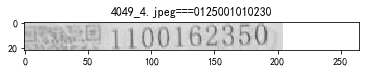

6483_9.jpeg===10015435


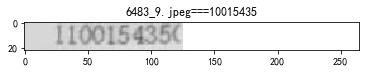

4165_3.jpeg===105403157


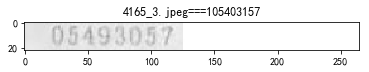

6472_6.jpeg===0084.87185


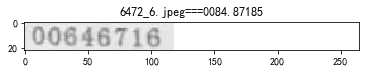

4150_10.jpeg===1.101011014073031


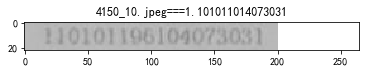

214_26.jpeg===1.4014,0032.01


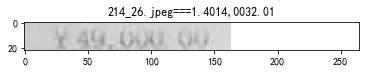

6641_24.jpeg===3760000.0013


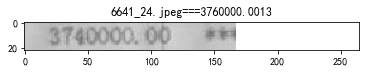

4222_28.jpeg===7014.505.00


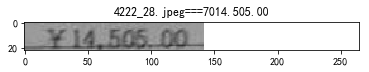

3038_15.jpeg===￥30,00,00


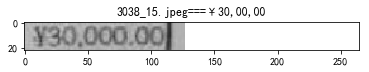

202_20.jpeg===145,536.419


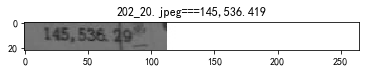

247_23.jpeg===￥00,002.00


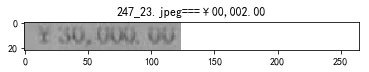

7007_3.jpeg===1731350480


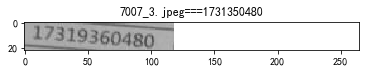

4202_32.jpeg===725800001684


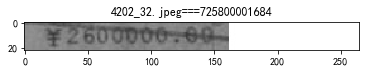

4241_12.jpeg===37031108702285273


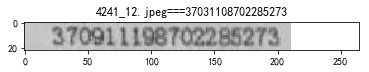

6464_3.jpeg===046.424.0


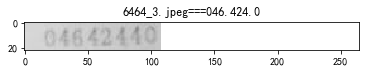

224_23.jpeg===025,0085,.003


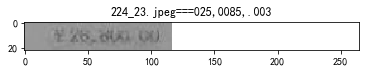

6623_39.jpeg===041.0000,.00


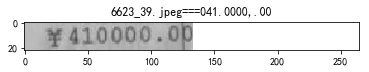

4209_11.jpeg===110103104052312158


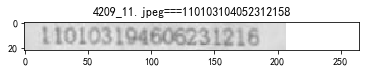

6474_46.jpeg===00000


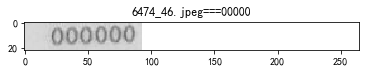

4242_28.jpeg===￥22,50.00


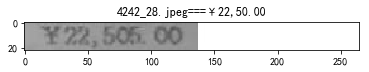

6660_32.jpeg===￥250000.00


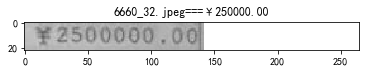

6462_50.jpeg===211011.2


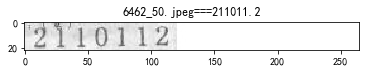

177_25.jpeg===￥31,050.00


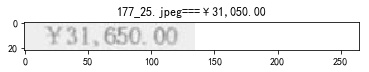

5007_11.jpeg===1100182350


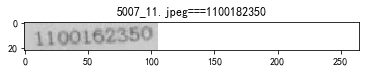

6242_12.jpeg===004434.05


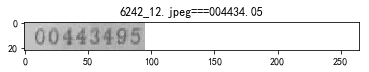

270_8.jpeg===2018


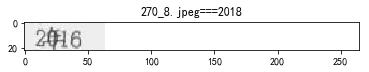

6640_4.jpeg===.17010413956


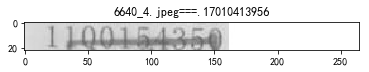

99_21.jpeg===320100120000027860


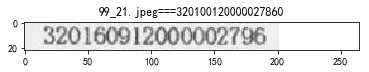

4002_11.jpeg===15,001.000


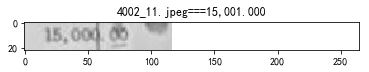

4208_29.jpeg===22100.00


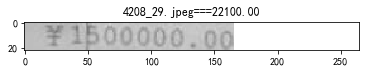

156_31.jpeg===￥3,370.1


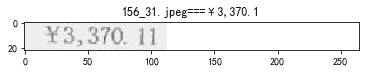

6454_29.jpeg===3740000.00


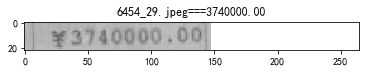

227_43.jpeg===4,085.712,


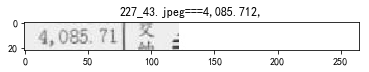

4027_8.jpeg===101041082070061


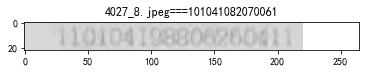

256_3.jpeg===71019


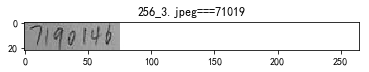

3054_32.jpeg===￥1230000,.00


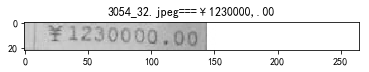

6633_57.jpeg===0035


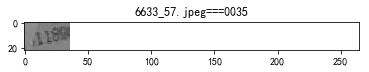

6648_6.jpeg===2027


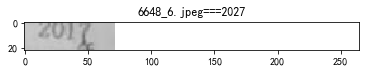

206_33.jpeg===￥24,305.00


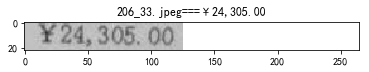

6624_26.jpeg===10880.0070,77


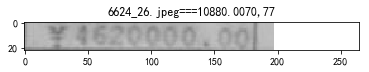

5023_8.jpeg===170102798510530028


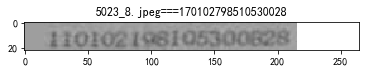

6604_10.jpeg===10102185308312323


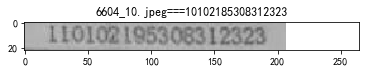

6448_24.jpeg===1170200.0


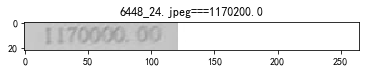

6613_28.jpeg===2470000.00


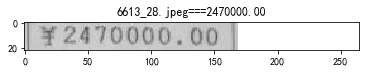

5156_12.jpeg===30021087023018


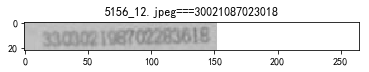

251_13.jpeg===11022710700120014


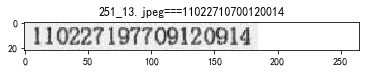

227_35.jpeg===32016100800003188


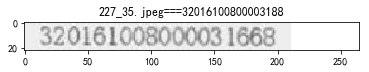

4191_11.jpeg===093698


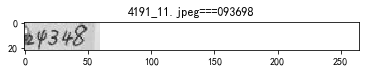

7021_21.jpeg===2170000045,0.0,00


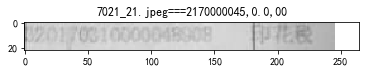

249_22.jpeg===￥55,888.875


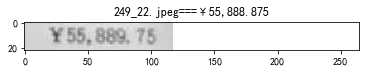

4172_11.jpeg===1108173460


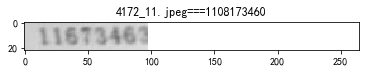

6454_8.jpeg===08185301002535


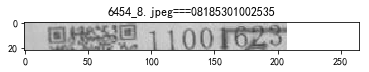

4009_37.jpeg===07030,8085.53


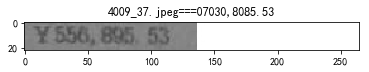

4024_25.jpeg===￥00,000.00


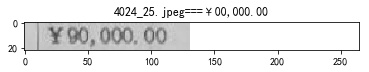

5024_23.jpeg===13011934547


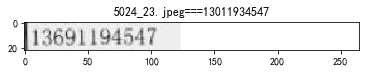

5420_24.jpeg===￥15,00.00


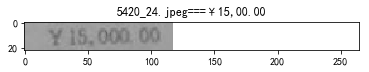

188_23.jpeg===2020,00


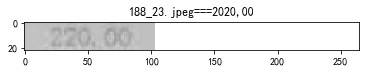

4239_24.jpeg===￥77,920.00


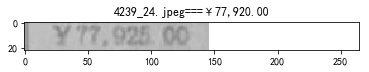

6464_39.jpeg===2101.06


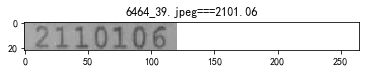

6446_41.jpeg===￥1457386.,13


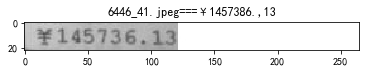

4176_6.jpeg===0987388


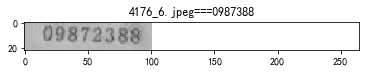

6608_1.jpeg===0587054


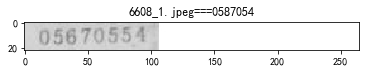

4002_49.jpeg===150000.003.


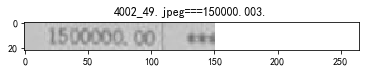

4051_47.jpeg===00000


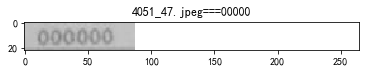

4039_25.jpeg===￥54,047.11


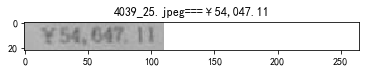

31_13.jpeg===11010210511415334


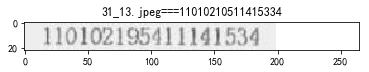

140_9.jpeg===21020210021012734


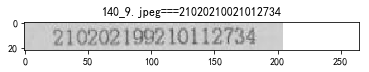

5008_2.jpeg===117123141


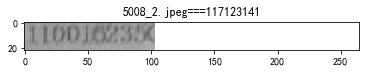

6224_9.jpeg===0035041.7


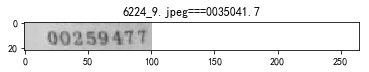

6454_44.jpeg===02110114


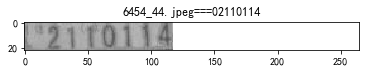

6206_16.jpeg===01341721.2


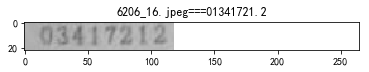

5167_36.jpeg===21.01.06


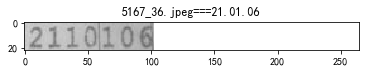

6474_51.jpeg===2011010


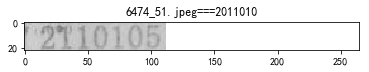

4009_29.jpeg===3,6086.44


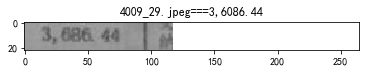

4159_2.jpeg===20183


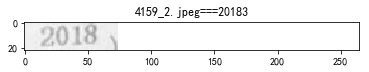

4017_35.jpeg===17470171


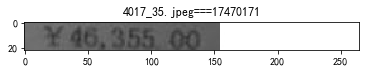

6624_5.jpeg===034854538


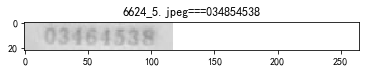

4031_29.jpeg===￥30,008.00


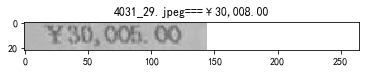

4051_33.jpeg===211010


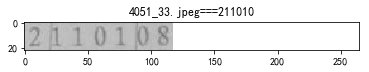

6635_1.jpeg===022803035


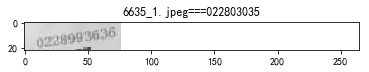

6674_6.jpeg===20107


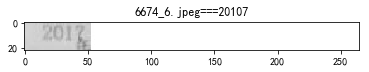

6438_34.jpeg===0150001.0


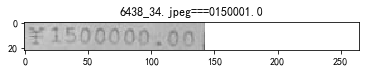

5037_28.jpeg===10800.00


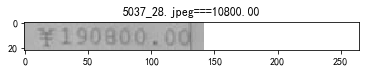

7008_24.jpeg===1513013071


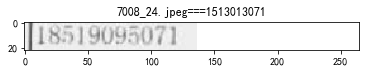

4002_33.jpeg===019930501101.6230


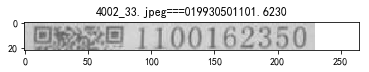

5176_11.jpeg===10048203350


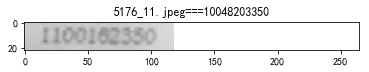

6614_6.jpeg===077842015


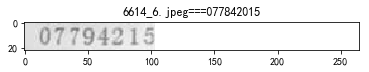

3002_15.jpeg===30,000,00


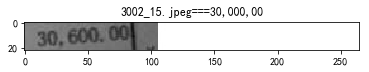

4051_6.jpeg===106440


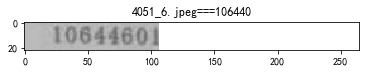

6458_38.jpeg===147.57


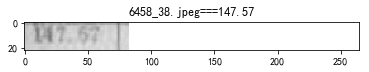

5150_29.jpeg===2437


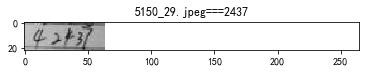

5158_8.jpeg===104


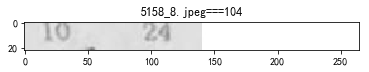

4209_26.jpeg===40,500.00


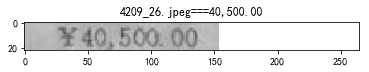

6420_2.jpeg===830934501015430


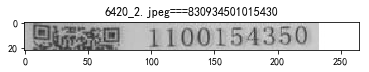

179_22.jpeg===3,801.


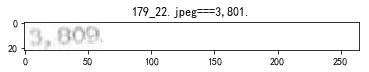

6655_49.jpeg===00000


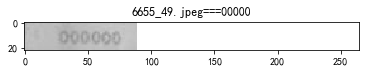

5041_4.jpeg===020391141


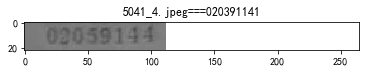

6617_26.jpeg===35047.83


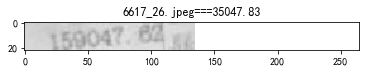

5037_3.jpeg===100182350


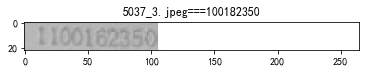

4188_40.jpeg===11


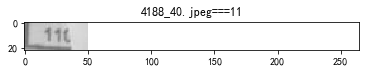

6682_38.jpeg===3201712200005223


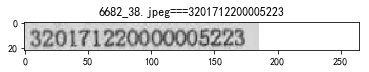

6605_2.jpeg===100162350


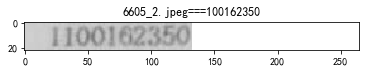

3011_29.jpeg===60213


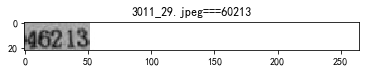

267_40.jpeg===08


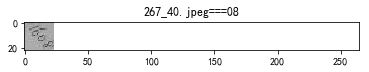

6464_28.jpeg===71.208.,1,7


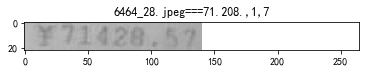

4225_8.jpeg===42092110115132


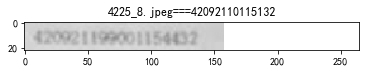

6466_29.jpeg===￥14,20071


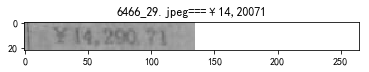

156_11.jpeg===372011082107845


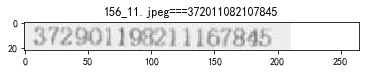

6441_3.jpeg===100182350


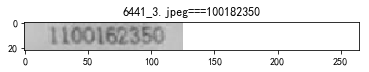

6633_15.jpeg===081000


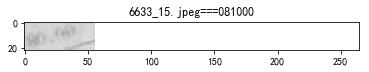

4165_39.jpeg===7.08513132136577


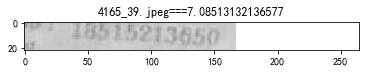

6612_7.jpeg===15212718510030213


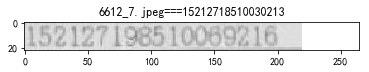

7010_9.jpeg===0212202001288536123


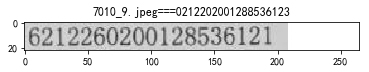

5007_13.jpeg===0013427733


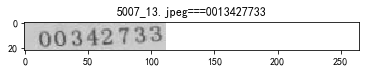

156_8.jpeg===20788


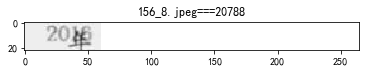

213_22.jpeg===120,000.00


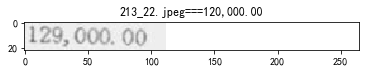

5017_18.jpeg===400500


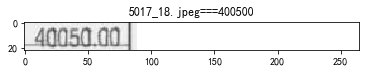

6491_26.jpeg===0797,0115,.00


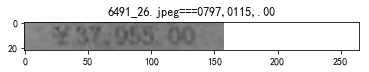

5008_3.jpeg===1703.03171172300


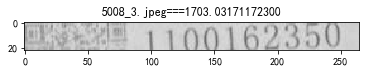

6498_3.jpeg===04422.5


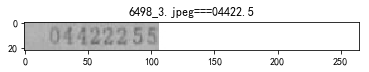

5176_33.jpeg===077


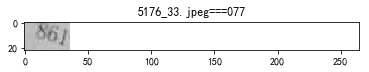

5032_60.jpeg===7110101


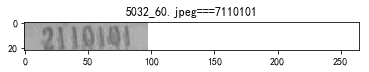

6207_6.jpeg===00545017


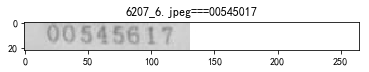

273_18.jpeg===1,40.000


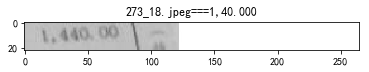

5024_39.jpeg===135810925208


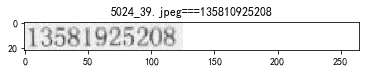

6635_0.jpeg===0865,


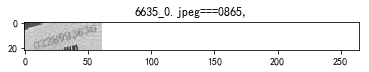

4151_11.jpeg===120102108500532317


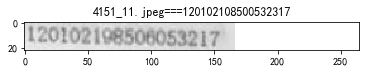

3063_20.jpeg===12,00.00


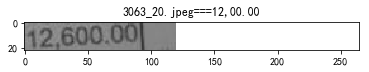

5020_31.jpeg===￥200000.00


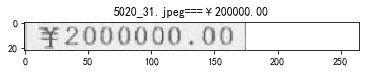

7023_31.jpeg===118000.0098


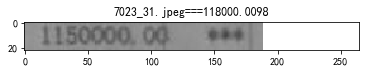

4049_5.jpeg===116848214


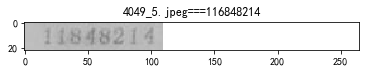

89_11.jpeg===101010620203040


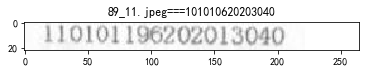

6611_8.jpeg===11010310870924023


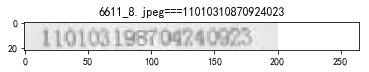

221_39.jpeg===00000770


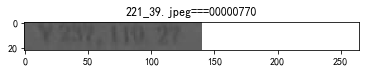

99_37.jpeg===000161435


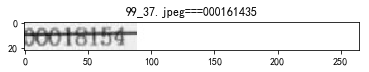

3002_3.jpeg===010000335


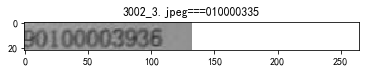

6655_6.jpeg===1.100154350


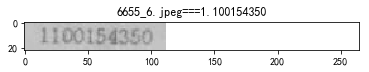

6416_20.jpeg===142,857.145


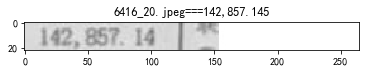

6429_24.jpeg===￥705,50,00


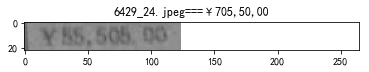

6626_11.jpeg===10018235


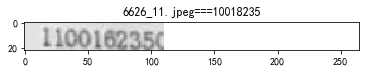

241_21.jpeg===127,00.00


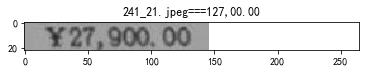

6463_5.jpeg===


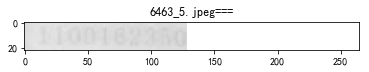

4212_10.jpeg===715649719034


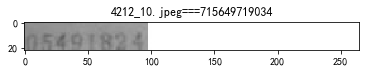

4005_39.jpeg===021.101


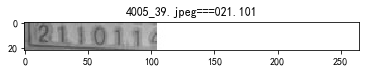

5007_38.jpeg===71.00000.00


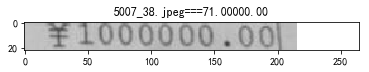

6635_26.jpeg===081.5000.0


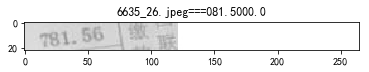

6639_3.jpeg===81100143535271


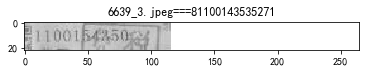

6472_25.jpeg===128.2884003.07873


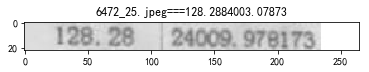

4202_41.jpeg===00000


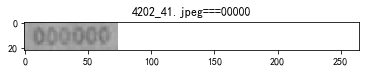

4184_0.jpeg===700.7


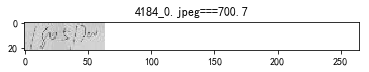

221_30.jpeg===77,011.707


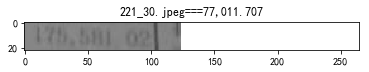

5020_4.jpeg===1100102350


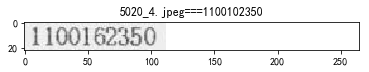

6639_13.jpeg===21.3.3021082.3200141


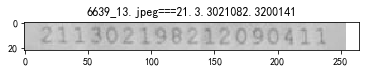

5412_28.jpeg===￥268,085.80


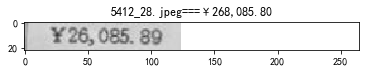

6237_40.jpeg===01101


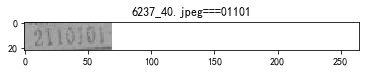

5037_14.jpeg===1501033.00


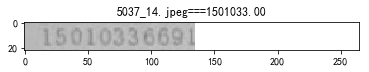

216_10.jpeg===0771


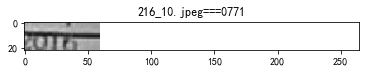

4163_20.jpeg===2180


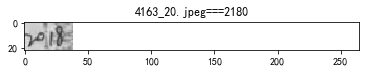

7019_5.jpeg===0199538


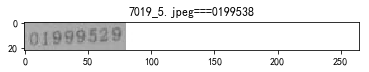

6614_32.jpeg===￥5100000.00


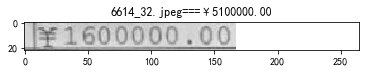

5160_59.jpeg===80177.337


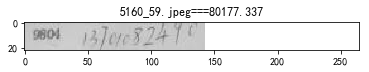

4024_21.jpeg===00,000.00


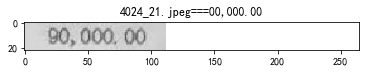

7015_6.jpeg===17172,30


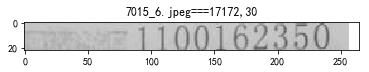

6609_11.jpeg===10101108307082041


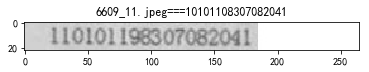

6641_6.jpeg===00801828


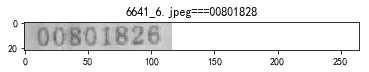

5030_6.jpeg===100154350


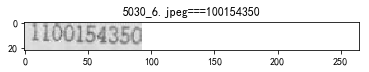

6438_0.jpeg===2852100.54350


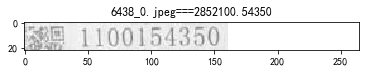

273_13.jpeg===005,4030.00


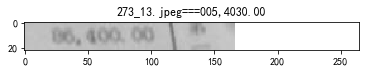

7023_12.jpeg===100154350


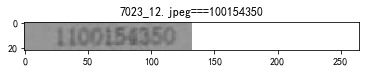

5039_11.jpeg===60101231080105101


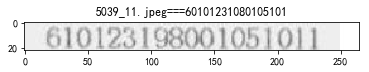

215_28.jpeg===715,075,773


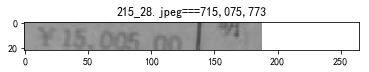

251_21.jpeg===3201001000000084


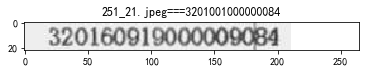

4244_23.jpeg===3201808300007077


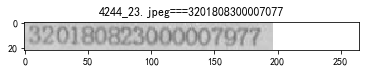

6446_54.jpeg===51042510120342


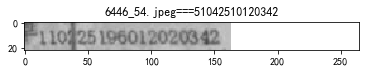

6448_3.jpeg===01010101.4300


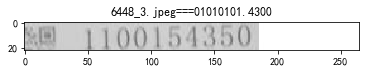

41_21.jpeg===3201008150001320.860


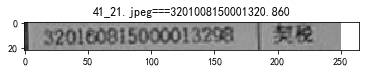

6237_8.jpeg===01831104


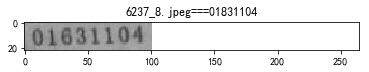

6449_20.jpeg===07.473811.250434


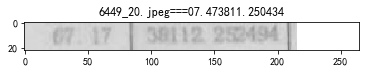

6237_6.jpeg===100154356


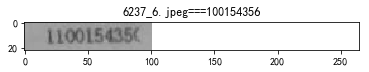

4002_60.jpeg===77368308053


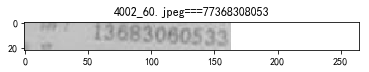

7019_7.jpeg===038010162350


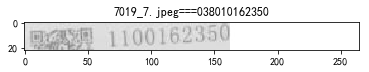

5158_6.jpeg===201616


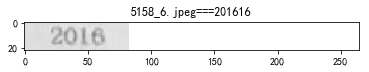

246_21.jpeg===￥29,000.00


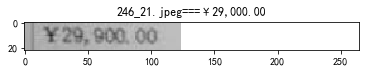

213_20.jpeg===020100800022455


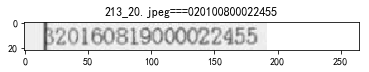

6655_8.jpeg===007804068


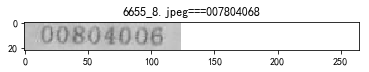

28_21.jpeg===340821075102518


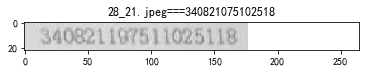

6455_18.jpeg===32017010000,.000


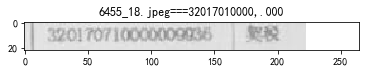

4158_5.jpeg===00870358


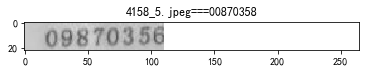

6635_14.jpeg===10.050186151


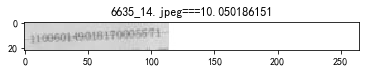

6660_33.jpeg===32.101.14


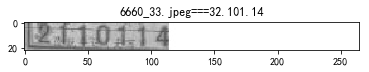

4017_28.jpeg===46,350


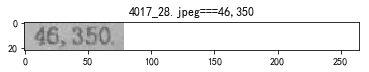

5408_21.jpeg===32010823000728035


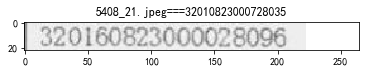

5176_45.jpeg===211211377


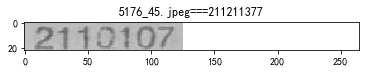

40_8.jpeg===170102798510530028


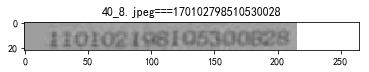

5030_29.jpeg===￥310000.00


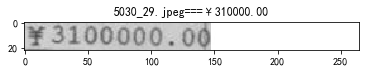

6410_24.jpeg===46,7005.


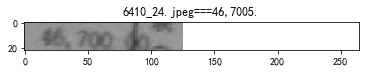

6613_3.jpeg===1001602350


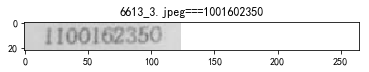

6220_54.jpeg===3270000070


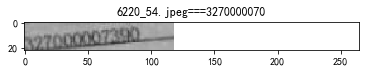

4208_6.jpeg===0018244


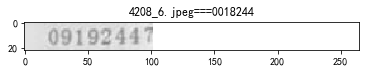

7019_34.jpeg===2310,.0


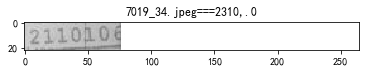

41_17.jpeg===3201008150001328010.00


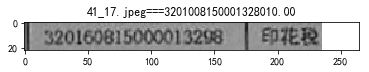

270_6.jpeg===051


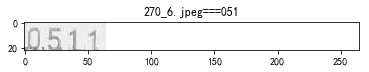

6441_5.jpeg===006633805


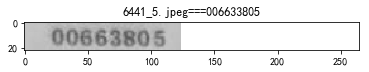

5032_16.jpeg===1001462350


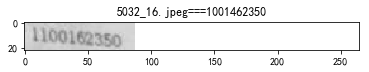

203_24.jpeg===210,723.580


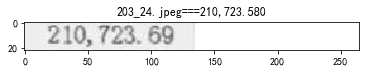

6605_5.jpeg===05870473


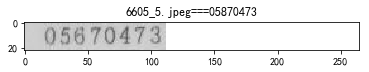

4226_37.jpeg===￥6508532.38


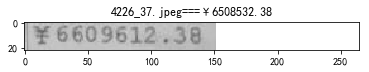

4191_24.jpeg===206,


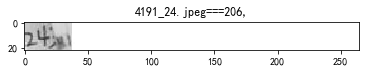

5043_38.jpeg===0742.053430


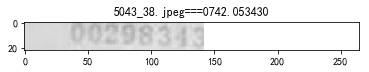

5040_16.jpeg===110105100083135


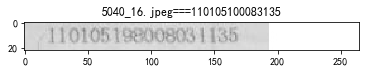

6641_31.jpeg===1210114


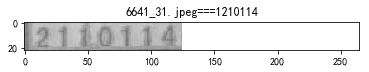

6221_37.jpeg===305796


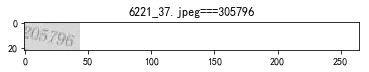

6206_51.jpeg===2110.110.7


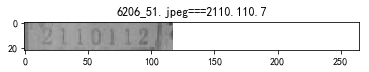

总的图片数量是639,错误的是563,正确率为11.893583724569638


In [6]:
lz.displot(Right=False, n_size=-1)


3029_15.jpeg===20,500.00


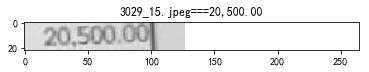

218_20.jpeg===￥15,000.00


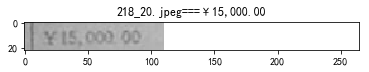

6470_22.jpeg===￥15,000.00


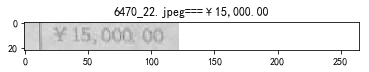

6483_36.jpeg===￥2000000.00


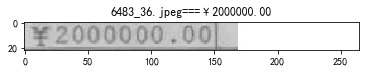

6209_2.jpeg===1100162350


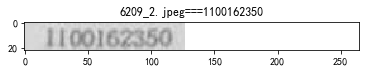

4021_26.jpeg===￥22,505.00


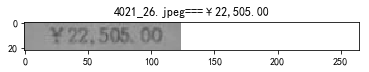

3004_18.jpeg===31,400.00


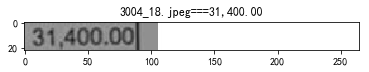

7019_27.jpeg===571428.57


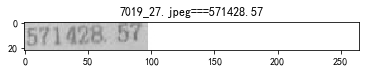

5413_27.jpeg===￥37,800.00


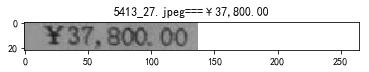

6636_7.jpeg===07794341


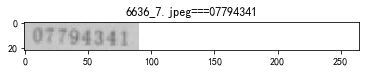

4027_23.jpeg===￥31,000.00


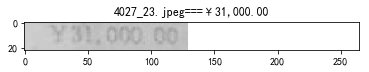

6441_23.jpeg===26201.00


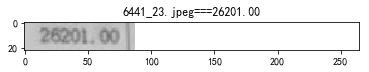

4039_20.jpeg===54,642.11


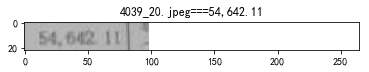

3029_18.jpeg===￥20,500.00


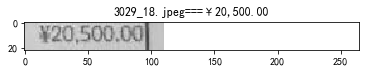

6623_13.jpeg===1100162350


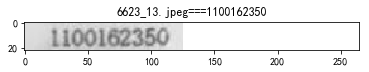

4002_20.jpeg===￥15,005.00


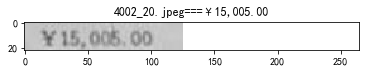

6639_8.jpeg===00801824


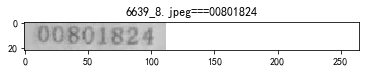

50_28.jpeg===￥22,500.00


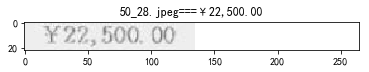

6410_26.jpeg===￥46,705.00


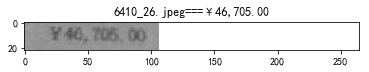

6445_17.jpeg===80


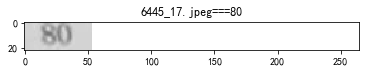

6474_17.jpeg===18500825325


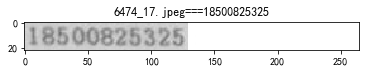

6641_4.jpeg===1100154350


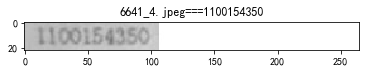

5030_8.jpeg===02047884


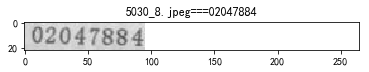

4179_20.jpeg===80.00


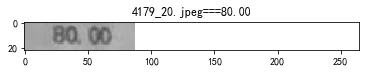

256_23.jpeg===30,000.00


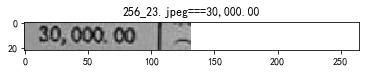

6209_5.jpeg===01453420


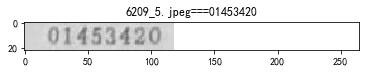

4051_45.jpeg===13701204400


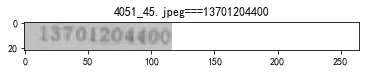

4215_30.jpeg===￥112,205.00


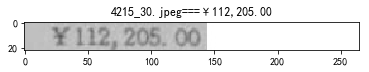

6219_6.jpeg===22


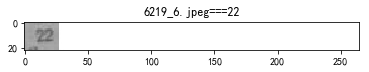

6623_49.jpeg===15810233176


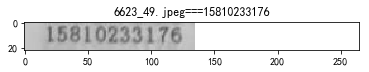

6435_5.jpeg===2017


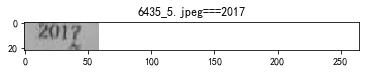

5032_58.jpeg===000000


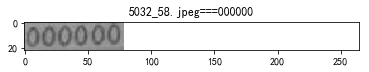

6421_18.jpeg===01


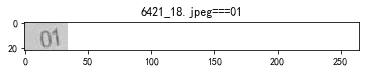

89_26.jpeg===￥10,000.00


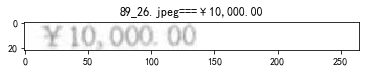

256_26.jpeg===￥30,005.00


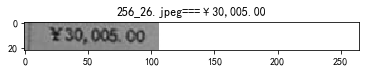

6488_40.jpeg===￥78,857.14


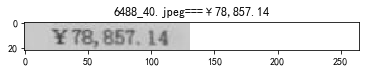

6470_18.jpeg===15,000.00


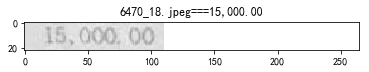

234_24.jpeg===￥22,500.00


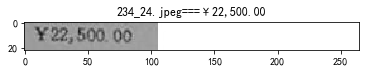

3011_26.jpeg===￥40,005.00


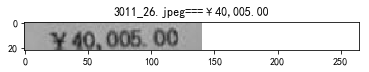

7023_14.jpeg===01633570


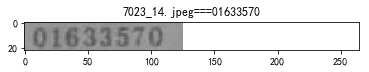

4022_22.jpeg===￥31,800.00


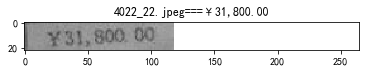

4218_24.jpeg===￥15,000.00


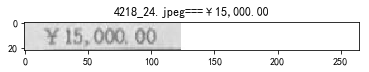

6477_20.jpeg===01


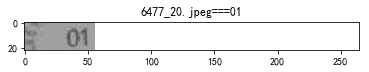

6630_27.jpeg===￥1367705.20


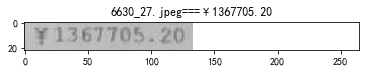

216_32.jpeg===￥15,005.00


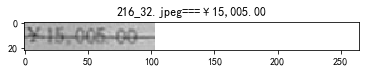

6207_41.jpeg===13401156767


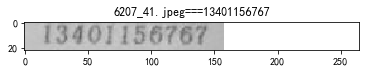

140_34.jpeg===￥24,202.05


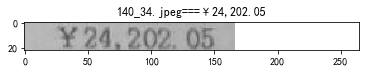

6660_5.jpeg===00804033


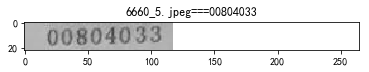

4244_31.jpeg===￥33,005.00


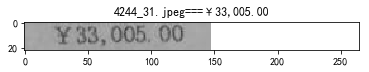

6477_14.jpeg===350


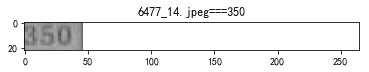

6417_23.jpeg===￥70,050.00


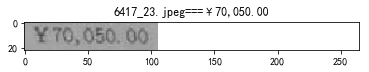

5408_28.jpeg===￥12,500.00


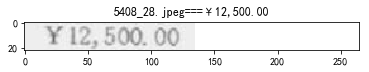

99_27.jpeg===￥14,720.00


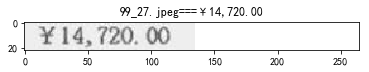

4213_24.jpeg===28,000.00


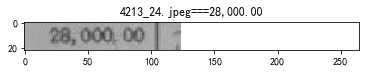

6474_8.jpeg===03554581


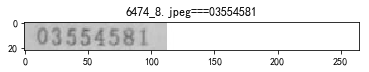

6623_17.jpeg===07738087


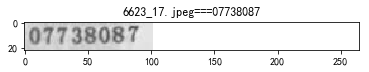

255_22.jpeg===￥30,000.00


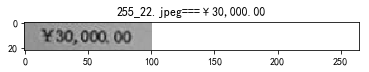

4051_17.jpeg===722763


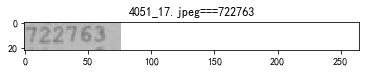

4213_27.jpeg===￥28,005.00


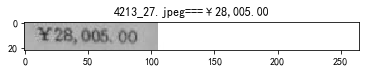

4026_26.jpeg===￥1000000.00


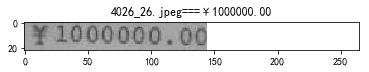

4232_22.jpeg===￥34,000.00


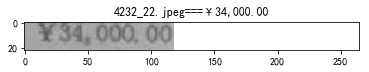

253_25.jpeg===53,700.00


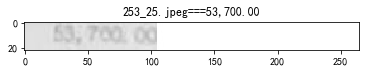

270_32.jpeg===￥505.00


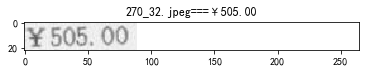

3023_2.jpeg===90100024140


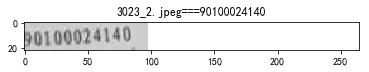

265_25.jpeg===￥18,000.00


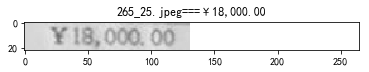

188_24.jpeg===￥13,148.57


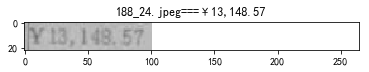

41_28.jpeg===￥15,005.00


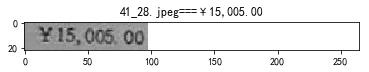

6485_22.jpeg===￥72,000.00


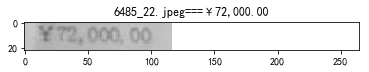

4043_27.jpeg===￥51,755.00


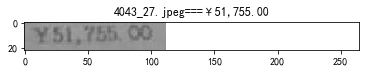

6416_29.jpeg===4,285.71


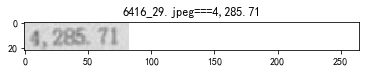

4209_23.jpeg===40,500.00


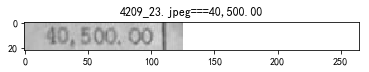

3053_18.jpeg===136,500.00


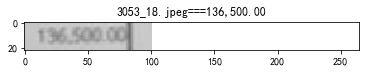

178_26.jpeg===￥14,300.00


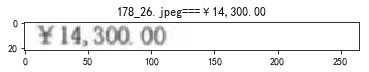

3004_22.jpeg===￥31,400.00


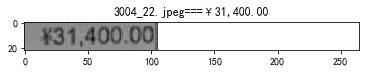

4053_19.jpeg===￥15,000.00


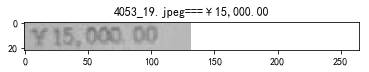

总的图片数量是639,其中正确的是74,正确率为11.580594679186229


In [7]:
lz.displot(Right=True, n_size=-1)